In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

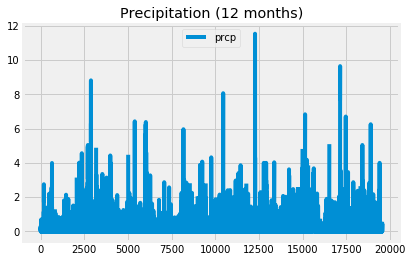

In [247]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


# Calculate the date 1 year ago from the last data point in the database
year_before = parse(last_date[0]) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
scores_df = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date > str(last_date)).\
    order_by(Measurement.date).all()
scores_df = pd.DataFrame(scores_df).sort_values(by=['date'])

scores_df.prcp.plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation.png")
plt.show()


In [248]:
# Use Pandas to calcualte the summary statistics for the precipitation data
scores_df.prcp.describe()


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

In [83]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(Station.id, Station.station).all()
stations

[(1, 'USC00519397'),
 (2, 'USC00513117'),
 (3, 'USC00514830'),
 (4, 'USC00517948'),
 (5, 'USC00518838'),
 (6, 'USC00519523'),
 (7, 'USC00519281'),
 (8, 'USC00511918'),
 (9, 'USC00516128')]

In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [115]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_info= session.query(Measurement.tobs).filter(Measurement.station==most_active[0][0]).all()
most_active_df=pd.DataFrame(list(most_active_info))
min_temp = most_active_df.min()
max_temp = most_active_df.max()
mean_temp = most_active_df.mean()

most_active_records = [(min_temp[0], max_temp[0], mean_temp[0])]
most_active_records

[(54.0, 85.0, 71.66378066378067)]

In [116]:
# Choose the station with the highest number of temperature observations.
highest_temp=session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
highest_temp_stations= highest_temp[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12month = session.query(Measurement.tobs).filter(Measurement.station == highest_temp_stations).\
    filter(Measurement.date > str(year_before)).all()
high_tem_station_12month= pd.DataFrame(last_12month)


Text(0,0.5,'Frequency')

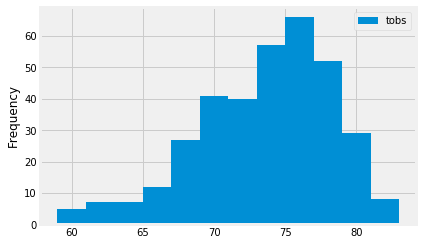

In [117]:
plt.hist(high_tem_station_12month["tobs"], bins=12)
plt.legend(["tobs"])
plt.ylabel("Frequency")

In [118]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [119]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip 
#using the previous year's data for those same dates.
trip_start = str(year_before)
trip_end= last_date[0]
trip_data = calc_temps(trip_start, trip_end)
print(trip_data)


[(58.0, 74.57894736842105, 87.0)]


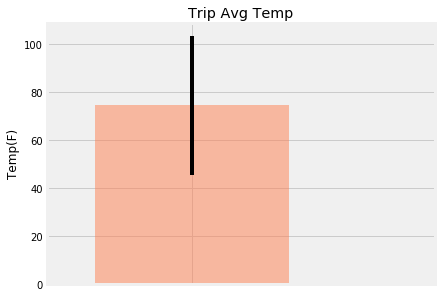

In [120]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_axis = trip_data[0][1]

plt.xlim(0.4, 2)

y_err = [trip_data[0][2] - trip_data[0][0]]
plt.bar( 1,y_axis, yerr=y_err, tick_label="", color='coral', alpha=0.5)

plt.tight_layout()
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')

plt.show()

In [244]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query( Measurement.station,\
                         Station.name, Station.latitude, Station.longitude, Station.elevation).\
filter(Measurement.station== Station.station).\
filter(Measurement.date <= trip_start).\
filter(Measurement.date <= trip_end).group_by(Station.station).\
order_by(Measurement.prcp.desc()).all()


rainfall_df = pd.DataFrame(rainfall)
rainfall_df.to_csv('Resources/rainfall.csv')

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
